## IMPORTER LES LIBRAIRIES

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import cv2
import pandas as pd
from my_site.image.utilities.Path_Join import p_join
from dateutil.relativedelta import relativedelta
from my_site.image.Traitement_image.Preprocessing_for_cropped import preproc_and_crop

## FUZZY C MEANS IMPLEMENTION

In [36]:
class FCM:
    def __init__(self, image, image_bit, n_clusters, m, epsilon, max_iter):
        """Modified Fuzzy C-means clustering
        <image>: 2D array, grey scale image.
        <n_clusters>: int, number of clusters/segments to create.
        <m>: float > 1, fuzziness parameter. A large <m> results in smaller
             membership values and fuzzier clusters. Commonly set to 2.
        <max_iter>: int, max number of iterations.
        """

        # -------------------Check inputs-------------------

        if np.ndim(image) != 2:
            raise Exception("<image> needs to be 2D (gray scale image).")
        if n_clusters <= 0 or n_clusters != int(n_clusters):
            raise Exception("<n_clusters> needs to be a positive integer.")
        if m < 1:
            raise Exception("<m> needs to be > 1.")
        if epsilon <= 0:
            raise Exception("<epsilon> needs to be > 0")

        self.result_def = None
        self.c = None
        self.u = None
        self.image = image
        self.image_bit = image_bit
        self.n_clusters = n_clusters  # number of clusters/segments to create
        self.m = m  # fuzziness parameter
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.shape = image.shape  # image shape
        self.X = image.flatten().astype('float')  # shape: (number of pixels)
        self.numPixels = image.size

    # ---------------------------------------------
    def initial_u(self):
        # each jth cluster (column) contains the cluster membership of the ith data point (ith row)
        # the sum of the memberships for each data point is equal to one.

        u = np.zeros((self.numPixels, self.n_clusters))
        idx = np.arange(self.numPixels)
        for ii in range(self.n_clusters):
            idxii = idx % self.n_clusters == ii
            u[idxii, ii] = 1
        return u

    def update_u(self):
        """Compute weights (cluster memberships)"""
        c_mesh, idx_mesh = np.meshgrid(self.c, self.X)  # self.c centroids of the clusters
        power = 2. / (self.m - 1)  # self.c defined in form_clusters()
        a = abs(idx_mesh - c_mesh) ** power
        b = np.sum((1. / abs(idx_mesh - c_mesh)) ** power, axis=1)

        return 1. / (a * b[:, None])

    def update_c(self):
        """Compute centroid of clusters"""  # vectorization in python to speed up the computing time
        numerator = np.dot(self.X, self.u ** self.m)
        denominator = np.sum(self.u ** self.m, axis=0)
        return numerator / denominator  # returns a matrix of shape (1,num_centroids)

    def form_clusters(self):
        """Iterative training"""
        d = 100
        self.u = self.initial_u()  # initializing the weights
        if self.max_iter != -1:
            i = 0
            self.iterate(i, True)
        else:
            i = 0
            self.iterate(i, d > self.epsilon)
        self.segmentimage()

    def iterate(self, i, condition):
        cnt = 0
        start_dt1 = datetime.datetime.now()
        while condition:
            start_dt = datetime.datetime.now()
            cnt += 1
            self.c = self.update_c()  # compute the centroids of the clusters
            old_u = np.copy(self.u)
            self.u = self.update_u()
            d = np.sum(abs(self.u - old_u))
            end_dt = datetime.datetime.now()
            diff = relativedelta(end_dt, start_dt)
            print("iter: %s, time interval: %s:%s:%s:%s" % (
                cnt, diff.hours, diff.minutes, diff.seconds, diff.microseconds))
            print("Iteration %d : cost = %f" % (i, d))

            if d < self.epsilon or i > self.max_iter:
                print('Converge at iteration {}'.format(cnt))
                end_dt1 = datetime.datetime.now()
                diff = relativedelta(end_dt1, start_dt1)
                print("duration time: %s:%s:%s:%s" % (diff.hours, diff.minutes, diff.seconds, diff.microseconds))
                break
            i += 1

    def defuzzify(self):
        return np.argmax(self.u, axis=1)  # Returns the indices of the maximum values along an axis.
        # returns the max membership value of each data point

    def segmentimage(self):
        """Segment image based on max weights"""

        result_def = self.defuzzify()
        self.result_def = result_def.reshape(self.shape).astype('int')*255

        return self.result_def

P_00017\LEFT_CC\full_mammo.jpg


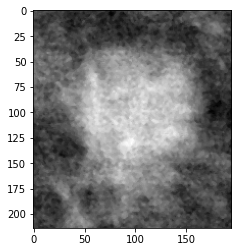

In [37]:
df = pd.read_excel(r"C:\Users\Asus\Desktop\PCD\Organized dataset\metadata\metadata_good2.0.xlsx")
parent_dir = r'C:\Users\Asus\Desktop\PCD\Organized dataset\curated'
number = 10
image = mpimg.imread(p_join(parent_dir, df['image full mammo path'][number]))
center = eval(df['center of roi'][number])
shape = eval(df['Shape of cropped image'][number])
crop = preproc_and_crop(image, center, shape)
plt.imshow(crop, cmap='gray')
print(df['image full mammo path'][number])

In [38]:
            #--------------Clustering------------
cluster = FCM(crop, image_bit=8, n_clusters=3, m=2.5, epsilon=0.000001, max_iter=1000)
cluster.form_clusters()
result = cluster.result_def


iter: 1, time interval: 0:0:0:47872
Iteration 0 : cost = 55647.663524
iter: 2, time interval: 0:0:0:92752
Iteration 1 : cost = 693.061248
iter: 3, time interval: 0:0:0:82778
Iteration 2 : cost = 1758.044557
iter: 4, time interval: 0:0:0:58844
Iteration 3 : cost = 4587.368760
iter: 5, time interval: 0:0:0:65823
Iteration 4 : cost = 9691.475492
iter: 6, time interval: 0:0:0:49867
Iteration 5 : cost = 14758.226059
iter: 7, time interval: 0:0:0:42887
Iteration 6 : cost = 15352.136283
iter: 8, time interval: 0:0:0:42887
Iteration 7 : cost = 11615.872678
iter: 9, time interval: 0:0:0:56846
Iteration 8 : cost = 7351.542510
iter: 10, time interval: 0:0:0:81294
Iteration 9 : cost = 4086.834836
iter: 11, time interval: 0:0:0:105231
Iteration 10 : cost = 2092.478399
iter: 12, time interval: 0:0:0:78788
Iteration 11 : cost = 1035.230406
iter: 13, time interval: 0:0:0:94745
Iteration 12 : cost = 533.531930
iter: 14, time interval: 0:0:0:78790
Iteration 13 : cost = 312.486866
iter: 15, time interval

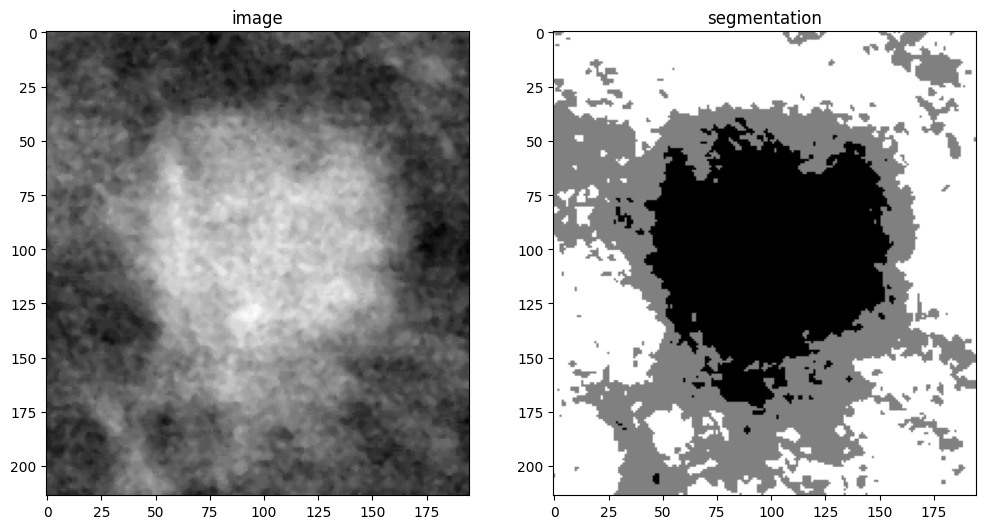

In [39]:
fig = plt.figure(figsize=(12, 8), dpi=100)

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(crop, cmap='gray')
ax1.set_title('image')

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(result, cmap='gray')
ax2.set_title('segmentation')

plt.show(block=False)
plt.close()

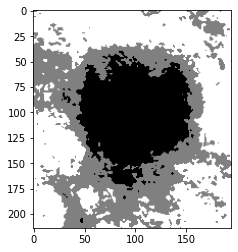

In [48]:
corners = [result[0][0], result[0][-1], result[-1][0], result[-1][-1]]
if corners.count(0) < 2:
    result = np.invert(result)
plt.imshow(result,cmap="gray")

In [49]:
np.unique(result)

array([  0, 255, 510])

In [50]:
print(result)

[[255 255 255 ... 510 510 510]
 [510 255 255 ... 510 510 510]
 [510 510 510 ... 510 510 510]
 ...
 [510 510 510 ... 510 510 510]
 [510 510 510 ... 510 510 510]
 [510 510 510 ... 510 510 510]]


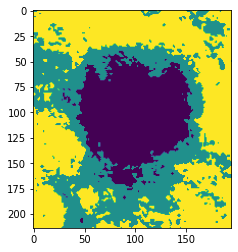

In [44]:
plt.imshow(result)

In [30]:
t = result.shape
abc = result
for i in range(t[0]):
    for j in range(t[1]):
        if result[i][j] == 0 or result[i][j]==result.max():
            abc[i][j] = 0
        else:
            abc[i][j] = 255

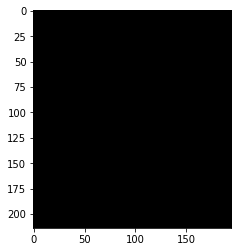

In [31]:
plt.imshow(abc,cmap="gray")

(144, 164)


True

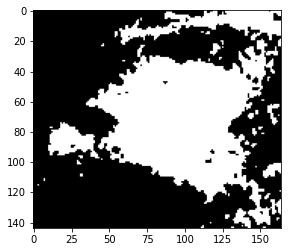

In [37]:
import cv2
from PIL import Image

plt.imshow(result, cmap='gray')
print(result.shape)

cv2.imwrite(
    r'C:\Users\Asus\PycharmProjects\pythonProject1\image test algorithms\FCM testing images\result_FCM_clusters_sample100.jpg',
    result * 255)

In [13]:
for a in [result]:
    print("Shape:", a.shape)
    print("Dimensions:", a.ndim)
    print("Type:", type(a))
    print("Data type:", a.dtype)
    print(f"min value, max value: {a.min(), a.max()}")
    print("---")

Shape: (144, 164)
Dimensions: 2
Type: <class 'numpy.ndarray'>
Data type: int32
min value, max value: (0, 1)
---


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Shape: (144, 164)
Dimensions: 2
Type: <class 'numpy.ndarray'>
Data type: uint8
min value, max value: (0, 255)
---


True

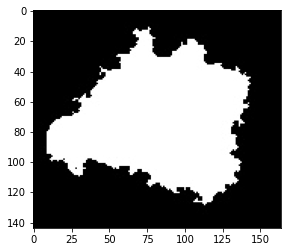

In [29]:
from my_site.image.Traitement_image.Crop_From_Center import crop_image_from_center
import cv2

gt = mpimg.imread(p_join(parent_dir, df['ROI mask file path'][number]))
res = r"C:\Users\Asus\PycharmProjects\pythonProject1\temp\aa.jpg"
gt_crop = crop_image_from_center(gt, center, shape)
print(gt_crop)
print("Shape:", gt_crop.shape)
print("Dimensions:", gt_crop.ndim)
print("Type:", type(gt_crop))
print("Data type:", gt_crop.dtype)
print(f"min value, max value: {gt_crop.min(), gt_crop.max()}")
print("---")
plt.imshow(gt_crop, cmap="gray")
cv2.imwrite(res, gt_crop)
#im = restore_mask(mask_path_gr,res,(515, 431),(2640, 444))


In [34]:
print(result.shape)
print(gt_crop.shape)

IoU is 0.5795868772782503
0.5795868772782503
Dice coefficient is 0.4810721544715447
0.4810721544715447


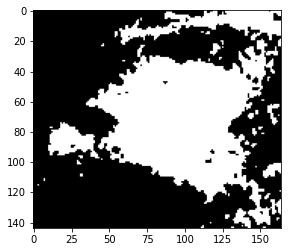

In [32]:
from my_site.image.utilities.IOU import iou
from my_site.image.utilities.Dice_coef import dice_coef

print(iou(gt_crop, result))
print(dice_coef(gt_crop, result))


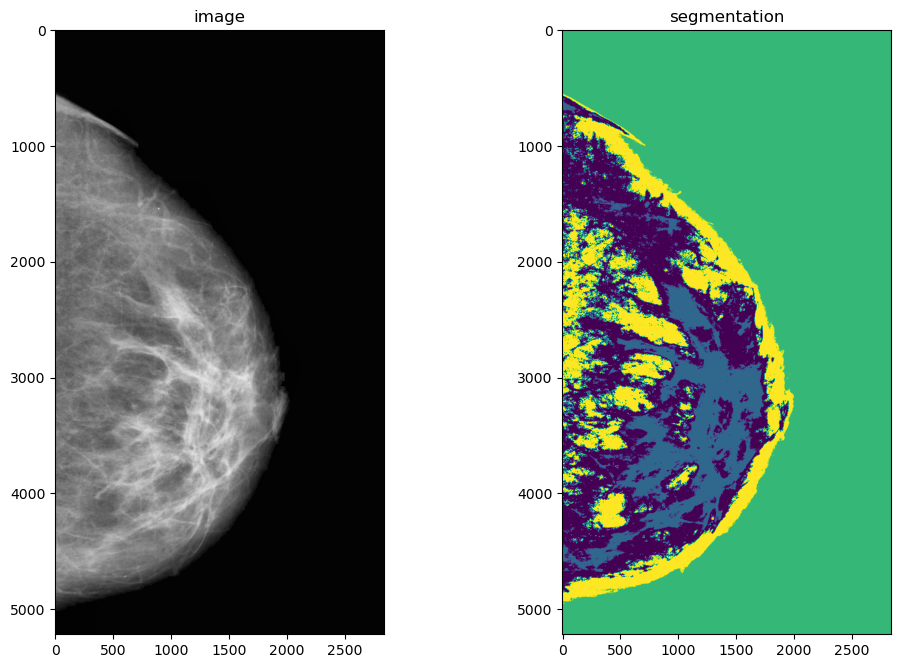